190363X_M.Loshanan

github link:

https://github.com/Loshanan/Image-processing


In [119]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [120]:
f = open(r'templeSparseRing/templeSR_par.txt', 'r')
assert f is not None

n = int(f.readline())

# Reading information in the first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# Reading information in the second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))


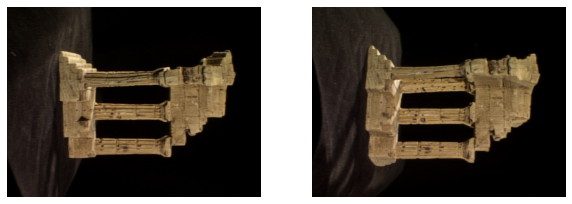

In [121]:
im1 = cv.imread(r'templeSparseRing/' + im1_fn, cv.IMREAD_COLOR)
im2 = cv.imread(r'templeSparseRing/' + im2_fn, cv.IMREAD_COLOR)

assert im1 is not None
assert im2 is not None
im1 = cv.cvtColor(im1, cv.COLOR_BGR2RGB)
im2 = cv.cvtColor(im2, cv.COLOR_BGR2RGB)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(im1)
ax[0].axis('off')
ax[1].imshow(im2)
ax[1].axis('off')
plt.show()


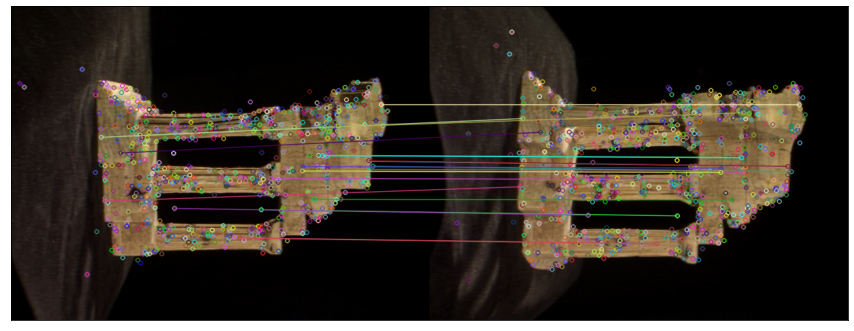

In [122]:
sift = cv.xfeatures2d.SIFT_create()
kp1, desc1 = sift.detectAndCompute(im1, None)
kp2, desc2 = sift.detectAndCompute(im2, None)

FLAWN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLAWN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(desc1, desc2, k=2)
good = []
pts1 = []
pts2 = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)
pts1 = np.array(pts1)
pts2 = np.array(pts2)

good = sorted(good, key = lambda x:x.distance)
im3 = cv.drawMatches(im1, kp1, im2, kp2, good[:20], im2)
plt.figure(figsize=(15,15))
plt.imshow(im3)
plt.xticks([]), plt.yticks([])
plt.show()

In [123]:
F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
print("Fundamental matrix\n", F)

Fundamental matrix
 [[ 3.62533688e-07  4.77529777e-06 -3.81330945e-02]
 [ 4.42118002e-06  4.08208895e-07 -3.89023680e-03]
 [ 3.59086437e-02 -7.72071366e-04  1.00000000e+00]]


In [124]:

E = K2.T @ F @ K1
retval, R, t, mask = cv.recoverPose(E, pts1, pts2, K1)

R_t_1 = np.concatenate((R1, t1), axis=1)
R2_ = R1 @ R
t2_ = R1 @ t
R_t_2 = np.concatenate((R2_, t2), axis=1)

P2_ = K2 @ R_t_2
print(P2_)

[[ 1.16187866e+02  1.54578858e+03 -7.18230990e+00  6.81806220e+01]
 [ 1.53244083e+03 -6.77884171e+01 -1.90644819e+02  1.99929996e+02]
 [ 4.73297573e-02  1.87460350e-01 -9.81131241e-01  6.00850565e-01]]


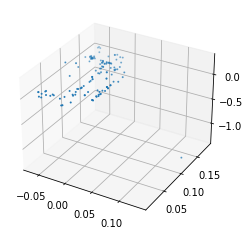

In [125]:
points4d = cv.triangulatePoints(P1, P2_, pts1.T, pts2.T)
points4d /= points4d[3, :]
X = points4d[0, :]
Y = points4d[1, :]
Z = points4d[2, :]
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1, cmap='gray')

plt.show()